In [9]:
import gym
import time
import torch
from torch import nn
import numpy as np
import copy
import random as rd
import matplotlib.pyplot as plt

from agent import Agent
from net import DeepQNet
from train import train

# Understanding the environment

In [13]:
env = gym.make('Boxing-ram-v0')
env.reset()

for i_episode in range(1):
    observation = env.reset()
    for t in range(200):
        time.sleep(0.02)
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

In [3]:
env.action_space

Discrete(18)

In [4]:
env.observation_space

Box(0, 255, (128,), uint8)

In [5]:
env.observation_space.low

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

# Deep Q Network

> https://towardsdatascience.com/qrash-course-deep-q-networks-from-the-ground-up-1bbda41d3677

> https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/

In [6]:
net = DeepQNet()
agent = Agent(net)
print(net)

DeepQNet(
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


Mean score over 5 last episodes: 1
Mean score over 5 last episodes: -1
Mean score over 5 last episodes: 4
Mean score over 5 last episodes: 3


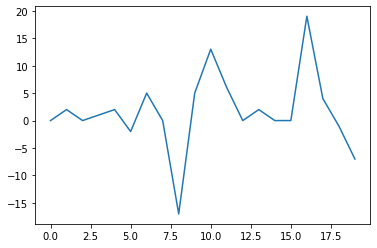

In [10]:
net, agent = train(n_episodes=20, n_steps_max=2000, print_ever_k_episodes=5)

# Pistes

> Implémenter UCB plutôt qu'epsilon greedy

> Hyperoptimisation (learning rate, architecture, epsilon, discount)

> Plus d'épisodes